## Project Introduction
In this project, we will look into Contrastive Divergence method of training an energy based model.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### Dataset
For the purpose of this project we will use the MNIST dataset

In [10]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(mnist, batch_size=64, shuffle=True)

### EBM
Here we will use a neural network as the energy function. The energy function will output a scalar.

In [5]:
class EBM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

### Contrastive Divergence Training
Remember that for getting $\nabla_{\theta} \log(p_{\theta})$, we need to compute:
$\nabla_{\theta} \log(p_{\theta}(x)) = -\nabla_{\theta}E_{\theta}(x) + \mathbb{E}_{x' \sim p_{\theta}}[\nabla_{\theta}E_{\theta}(x')]$

$x'$ is calculated by using MCMC

$x^{k+1} = x^{k} + \frac{\epsilon^2} {2}   \nabla_{\theta} \log(p_{\theta}(x)) + \epsilon z^k$

So we have positive phase: Minimize $E_{\theta}(x_{data})$ and negative phase: $E_{\theta}(x_{model})$

In [7]:
def get_mcmc_samples(x_init, ebm_model, num_steps=20, epsilon=0.1):
    x_neg = x_init.clone().detach().to(device)

    for _ in range(num_steps):
        x_neg.requires_grad = True
        energy = ebm_model(x_neg) 
        grad = torch.autograd.grad(energy.sum(), x_neg)[0]
        x_neg = x_neg - 0.5 * epsilon**2 * grad + epsilon * torch.randn_like(x_neg)
        
        x_neg = x_neg.detach()
        
    return x_neg


### Let's make a simple visualization script

In [12]:
def sample_and_visualize(model, steps=100, epsilon=0.1, n_samples=16):
    model.eval()

    # Step 1: Start from pure noise
    x_init = torch.rand((n_samples, 1, 28, 28)).to(device)

    # Step 2: Run long-run Langevin sampling
    x_sampled = get_mcmc_samples(x_init, model, num_steps=steps, epsilon=epsilon)

    # Step 3: Plot a grid of samples
    x_sampled = x_sampled.cpu().detach().clamp(0, 1)  # Clip values to [0, 1] for display

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sampled[i][0], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    model.train()  # Go back to training mode

## Let's train

In [13]:
model = EBM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 10

Epoch 1, Loss: 15.3334
Sampling from model...


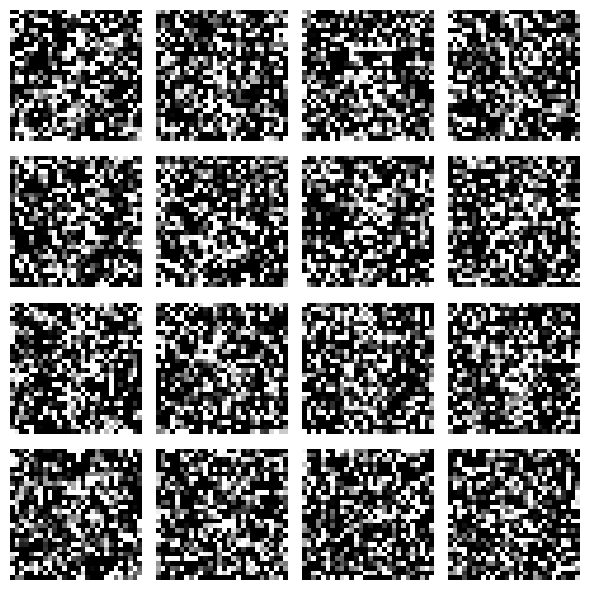

Epoch 2, Loss: 10.3896
Sampling from model...


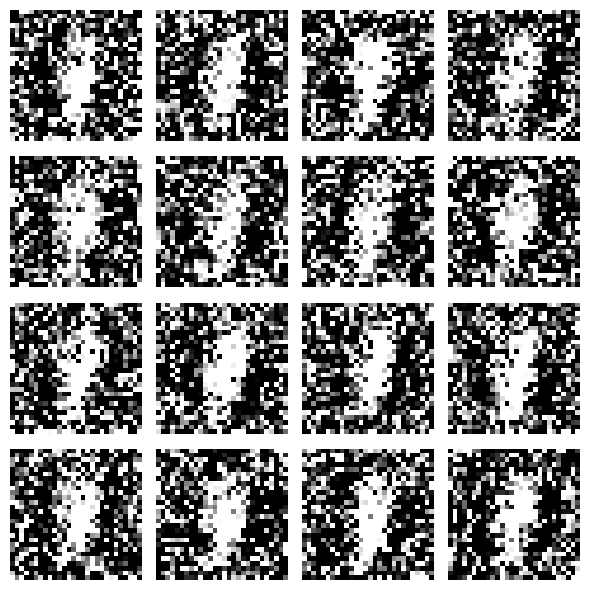

Epoch 3, Loss: -75543.5156
Sampling from model...


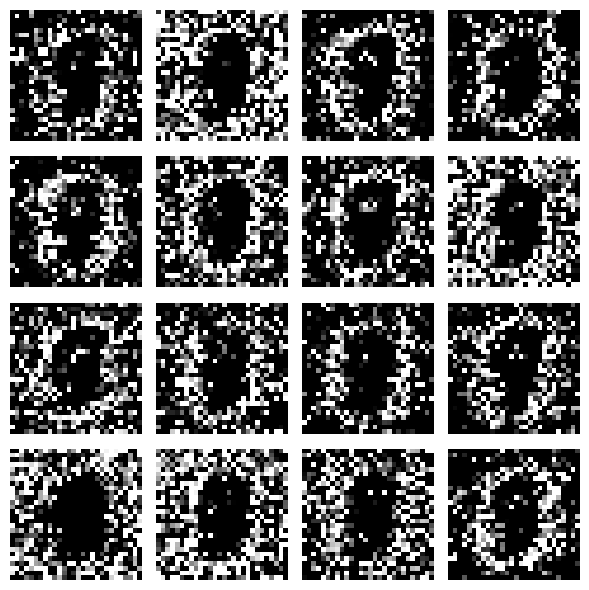

Epoch 4, Loss: -5481358336.0000
Sampling from model...


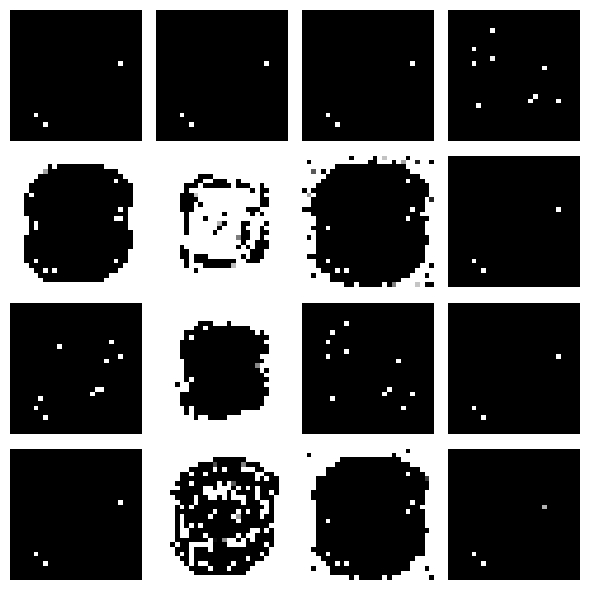

Epoch 5, Loss: -223878135808.0000
Sampling from model...


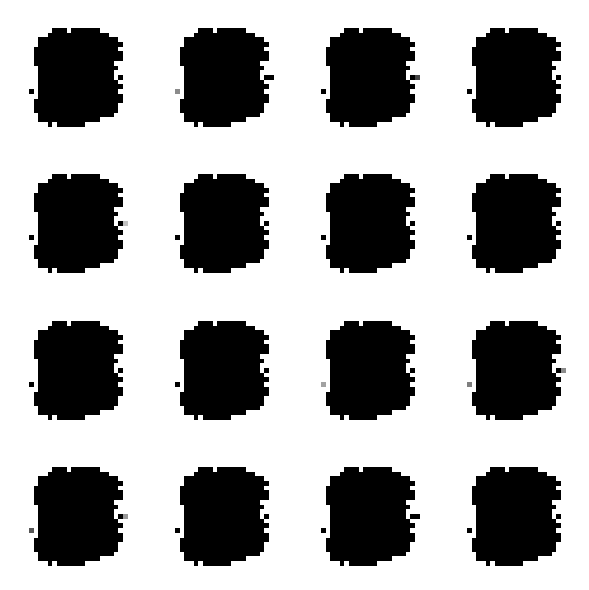

Epoch 6, Loss: -40199233536.0000
Sampling from model...


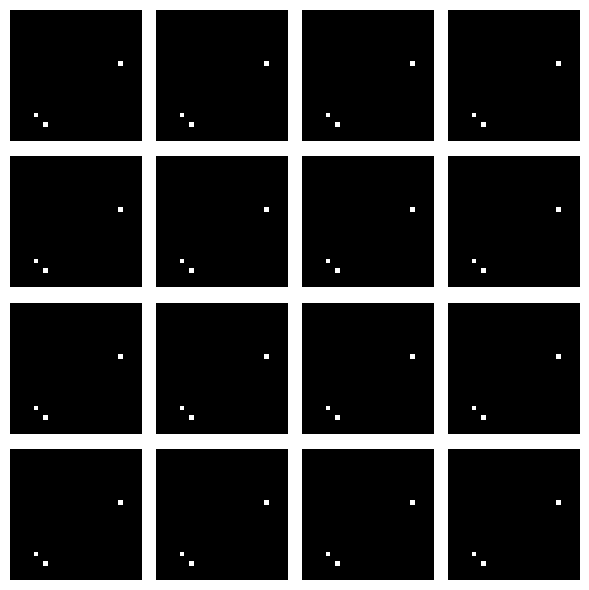

Epoch 7, Loss: -3298720768.0000
Sampling from model...


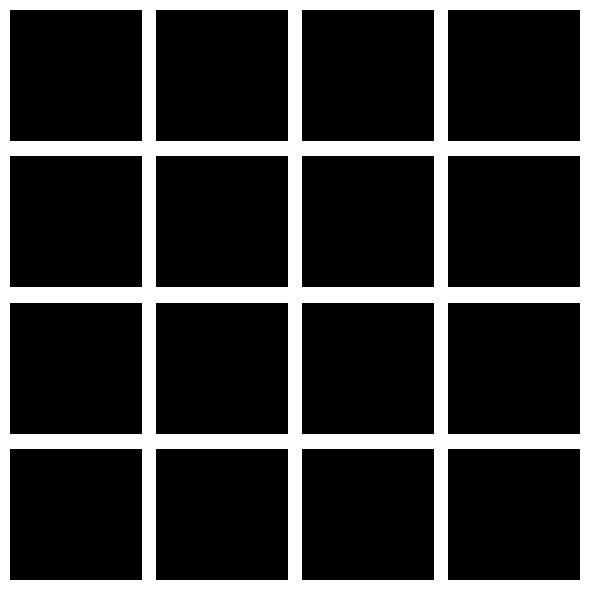

Epoch 8, Loss: -984107648.0000
Sampling from model...


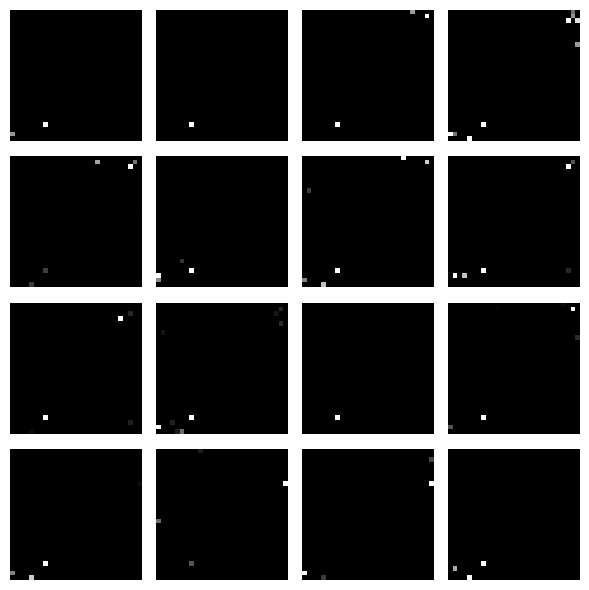

KeyboardInterrupt: 

In [14]:
for epoch in range(num_epochs):
    
    for x_data, _ in loader:
        x_data = x_data.to(device)

        # Step 1: Initialize x_neg from random noise or uniform image
        x_init = torch.rand_like(x_data)  # or torch.randn_like(x_data)
        x_neg = get_mcmc_samples(x_init, model, num_steps=20, epsilon=0.01)

        # Step 2: Compute energies
        energy_pos = model(x_data)       # E(x_data)
        energy_neg = model(x_neg)        # E(x_neg)

        # Step 3: Contrastive divergence loss
        loss = energy_pos.mean() - energy_neg.mean()

        # Step 4: Optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    print("Sampling from model...")
    sample_and_visualize(model, steps=100, epsilon=0.1)
